# Transformer Model
Training a transformer model to forecast time series sequence of stock closing price  
Using 10 timesteps to forecast 1 forward timestep

Imports

In [15]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

Load data and set global variables

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
input_window = 30 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv('/content/drive/MyDrive/data/final_merged.csv') # data path of facebook stock price (Apr 2019 - Nov 2020)
close = np.array(df['close'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

Plot shows the reduced scale of the closing prices

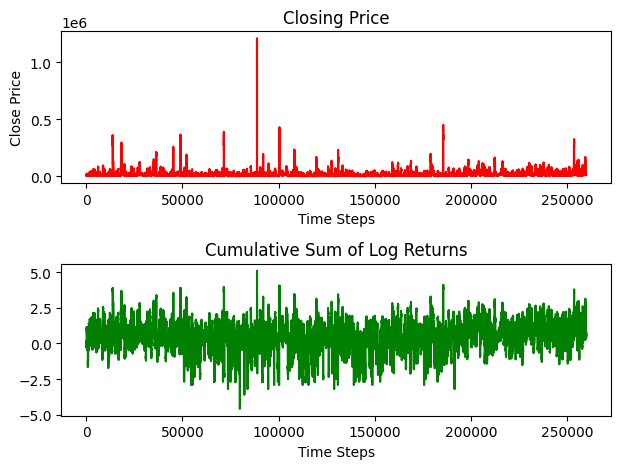

In [18]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='red')
axs[0].set_title('Closing Price')
axs[0].set_ylabel('Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

In [19]:

import os
import json
import math
import time
import pickle
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Config
# -----------------------------

@dataclass
class Config:
    csv_path: str = "/content/drive/MyDrive/data/final_merged.csv"        # path to your csv
    save_dir: str = "/content/drive/MyDrive/model"
    features: Tuple[str, ...] = ("open", "high", "low", "close", "volume")
    target_col: str = "close"
    input_window: int = 30              # number of past timesteps
    output_window: int = 1              # number of future timesteps to predict
    batch_size: int = 64
    num_epochs: int = 150
    lr: float = 1e-4
    weight_decay: float = 1e-4
    hidden_dim: int = 128
    n_heads: int = 8
    n_layers: int = 3
    emb_dim: int = 16                   # stock embedding size
    dropout: float = 0.1
    train_ratio: float = 0.8            # split per stock chronologically
    seed: int = 42
    use_cuda: bool = True

cfg = Config()

# Create save directory
os.makedirs(cfg.save_dir, exist_ok=True)

# -----------------------------
# Reproducibility
# -----------------------------

def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)

device = torch.device("cuda" if (torch.cuda.is_available() and cfg.use_cuda) else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Load & Preprocess
# -----------------------------

df = pd.read_csv(cfg.csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['ticker', 'timestamp']).reset_index(drop=True)

# Map stock to id
stocks = df['ticker'].unique().tolist()
stock2id: Dict[str, int] = {s: i for i, s in enumerate(stocks)}
id2stock: Dict[int, str] = {i: s for s, i in stock2id.items()}

df['stock_id'] = df['ticker'].map(stock2id)

# Scale features per stock (MinMax)
feature_cols = list(cfg.features)
scalers: Dict[str, MinMaxScaler] = {}

scaled_parts = []
for s, g in df.groupby('ticker', sort=False):
    scaler = MinMaxScaler()
    g_scaled = g.copy()
    g_scaled[feature_cols] = scaler.fit_transform(g[feature_cols])
    scaled_parts.append(g_scaled)
    scalers[s] = scaler

scaled_df = pd.concat(scaled_parts, axis=0).sort_values(['ticker', 'timestamp']).reset_index(drop=True)

# -----------------------------
# Train/Val Split (chronological per stock)
# -----------------------------

def split_per_stock(data: pd.DataFrame, train_ratio: float = 0.8) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_list = []
    val_list = []
    for s, g in data.groupby('ticker', sort=False):
        n = len(g)
        cut = int(n * train_ratio)
        train_list.append(g.iloc[:cut].copy())
        val_list.append(g.iloc[cut:].copy())
    train_df = pd.concat(train_list, axis=0).sort_values(['ticker', 'timestamp']).reset_index(drop=True)
    val_df = pd.concat(val_list, axis=0).sort_values(['ticker', 'timestamp']).reset_index(drop=True)
    return train_df, val_df

train_df, val_df = split_per_stock(scaled_df, cfg.train_ratio)


Using device: cuda


In [20]:
val_df

,timestamp,ticker,score,open,high,low,close,volume,stock_id
0,2025-07-16,A32,-2.5,0.177746,0.148121,0.264673,0.232598,0.000000,0
1,2025-07-17,A32,-2.5,0.177746,0.148121,0.264673,0.232598,0.000000,0
2,2025-07-18,A32,-1.5,0.177746,0.148121,0.264673,0.232598,0.000000,0
3,2025-07-21,A32,1.5,0.764175,0.636812,1.000000,1.000000,0.007692,0
4,2025-07-22,A32,2.0,0.764175,0.636812,1.000000,1.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...
52648,2025-08-25,YTC,-3.0,0.446336,0.277325,0.446336,0.302621,0.000000,1604
52649,2025-08-26,YTC,-1.5,0.446336,0.277325,0.446336,0.302621,0.000000,1604
52650,2025-08-27,YTC,-1.5,0.446336,0.277325,0.446336,0.302621,0.000000,1604
52651,2025-08-28,YTC,0.5,0.446336,0.277325,0.446336,0.302621,0.000000,1604


In [21]:
train_df

,timestamp,ticker,score,open,high,low,close,volume,stock_id
0,2025-01-02,A32,0.5,0.466667,0.388889,0.626953,0.610680,0.000000,0
1,2025-01-03,A32,-0.5,0.177778,0.148148,0.181120,0.172008,0.046154,0
2,2025-01-06,A32,-2.0,0.133333,0.111111,0.208984,0.174480,0.000000,0
3,2025-01-07,A32,0.0,0.133333,0.111111,0.208984,0.174480,0.000000,0
4,2025-01-08,A32,-1.0,0.133333,0.111111,0.208984,0.174480,0.000000,0
...,...,...,...,...,...,...,...,...,...
207389,2025-07-09,YTC,3.0,0.560584,0.416449,0.560584,0.433351,0.033898,1604
207390,2025-07-10,YTC,2.0,0.516642,0.339158,0.516642,0.370094,0.016949,1604
207391,2025-07-11,YTC,3.5,0.428759,0.319835,0.428759,0.318056,0.050847,1604
207392,2025-07-14,YTC,4.0,0.494672,0.339158,0.494672,0.363052,0.050847,1604


In [22]:

class MultiStockDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_cols: List[str], target_col: str,
                 input_window: int, output_window: int):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.input_window = input_window
        self.output_window = output_window
        self.samples = []  # (x_window, y_window, stock_id)
        self._build()

    def _build(self):
        for sid, g in self.df.groupby('stock_id', sort=False):
            values = g[self.feature_cols].values  # [T, F]
            target_idx = self.feature_cols.index(self.target_col)
            T = len(values)
            for i in range(T - self.input_window - self.output_window + 1):
                x = values[i:i + self.input_window]
                y = values[i + self.input_window:i + self.input_window + self.output_window, target_idx]
                self.samples.append((x.astype(np.float32), y.astype(np.float32), int(sid)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y, sid = self.samples[idx]
        return torch.from_numpy(x), torch.from_numpy(y), torch.tensor(sid, dtype=torch.long)

train_ds = MultiStockDataset(train_df, feature_cols, cfg.target_col, cfg.input_window, cfg.output_window)
val_ds   = MultiStockDataset(val_df,   feature_cols, cfg.target_col, cfg.input_window, cfg.output_window)


train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, drop_last=False)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")


Train samples: 159340 | Val samples: 4739


In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, D]
        T = x.size(1)
        return x + self.pe[:, :T]

# -----------------------------
# Model
# -----------------------------

class StockTransformer(nn.Module):
    def __init__(self, num_stocks: int, feature_dim: int, emb_dim: int, hidden_dim: int,
                 n_heads: int, n_layers: int, output_window: int, dropout: float = 0.1):
        super().__init__()
        self.stock_emb = nn.Embedding(num_stocks, emb_dim)
        self.input_proj = nn.Linear(feature_dim + emb_dim, hidden_dim)
        self.pos_enc = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=n_heads, dim_feedforward=hidden_dim * 4,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(hidden_dim, output_window)

    def forward(self, x: torch.Tensor, stock_ids: torch.Tensor) -> torch.Tensor:
        # x: [B, T, F]
        # stock_ids: [B]
        B, T, _ = x.shape
        s_emb = self.stock_emb(stock_ids)              # [B, E]
        s_emb = s_emb.unsqueeze(1).expand(B, T, -1)    # [B, T, E]
        h = torch.cat([x, s_emb], dim=-1)              # [B, T, F+E]
        h = self.input_proj(h)                         # [B, T, H]
        h = self.pos_enc(h)
        h = self.encoder(h)                            # [B, T, H]
        h_last = h[:, -1, :]                           # [B, H]
        y = self.head(self.dropout(h_last))            # [B, output_window]
        return y

In [24]:
# -----------------------------
# Metrics
# -----------------------------

def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred)).item()

def mape(y_true, y_pred, eps: float = 1e-6):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true.abs() + eps))).item() * 100.0

In [ ]:

# -----------------------------
# Training Loop
# -----------------------------

num_stocks = len(stocks)
feature_dim = len(feature_cols)

model = StockTransformer(
    num_stocks=num_stocks,
    feature_dim=feature_dim,
    emb_dim=cfg.emb_dim,
    hidden_dim=cfg.hidden_dim,
    n_heads=cfg.n_heads,
    n_layers=cfg.n_layers,
    output_window=cfg.output_window,
    dropout=cfg.dropout,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.num_epochs)

criterion = nn.L1Loss()

best_val = float('inf')
best_path = os.path.join(cfg.save_dir, 'model.pt')

for epoch in range(1, cfg.num_epochs + 1):
    t0 = time.time()

    # ---- Train ----
    model.train()
    train_losses = []
    for xb, yb, sid in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        sid = sid.to(device)

        optimizer.zero_grad()
        pred = model(xb, sid)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    scheduler.step()

    # ---- Validate (compute MAE on scaled; report too on original scale for info) ----
    model.eval()
    val_losses = []
    val_mae_orig = []
    val_mape_orig = []

    with torch.no_grad():
        for xb, yb, sid in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            sid = sid.to(device)
            pred = model(xb, sid)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

            # Inverse scale to original price for metrics (use each sample's stock scaler)
            # yb/pred are scaled target in [0,1]. We inverse using each stock's scaler and target column.
            target_idx = feature_cols.index(cfg.target_col)

            pred_np = pred.cpu().numpy()
            yb_np = yb.cpu().numpy()
            sid_np = sid.cpu().numpy()

            for i in range(pred_np.shape[0]):
                sname = id2stock[int(sid_np[i])]
                scaler = scalers[sname]

                # Build dummy arrays to inverse-transform target column
                # MinMaxScaler works column-wise; create arrays with correct number of columns
                # We place our target in the target column and zeros elsewhere (scaled zeros ~ min, but we only read target back)
                def inv(arr1d):
                    # arr1d shape: [output_window]
                    dummy = np.zeros((arr1d.shape[0], len(feature_cols)), dtype=np.float64)
                    dummy[:, target_idx] = arr1d
                    inv = scaler.inverse_transform(dummy)[:, target_idx]
                    return inv

                pred_orig = inv(pred_np[i])
                y_orig = inv(yb_np[i])

                mae_i = np.mean(np.abs(pred_orig - y_orig))
                mape_i = np.mean(np.abs((pred_orig - y_orig) / (np.abs(y_orig) + 1e-6))) * 100.0
                val_mae_orig.append(mae_i)
                val_mape_orig.append(mape_i)

    train_loss = float(np.mean(train_losses)) if train_losses else float('nan')
    val_loss = float(np.mean(val_losses)) if val_losses else float('nan')
    val_mae_o = float(np.mean(val_mae_orig)) if val_mae_orig else float('nan')
    val_mape_o = float(np.mean(val_mape_orig)) if val_mape_orig else float('nan')

    dt = time.time() - t0
    print(f"Epoch {epoch:03d}/{cfg.num_epochs} | time {dt:5.1f}s | "
          f"train_loss {train_loss:.5f} | val_loss {val_loss:.5f} | "
          f"val_MAE(orig) {val_mae_o:.4f} | val_MAPE(orig) {val_mape_o:.2f}%")

    # Save best by val_loss on scaled domain (you may switch to val_mae_o)
    if val_loss < best_val:
        best_val = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'cfg': asdict(cfg),
            'stock2id': stock2id,
            'id2stock': id2stock,
            'feature_cols': feature_cols,
        }, best_path)
        # Save scalers too
        with open(os.path.join(cfg.save_dir, 'scalers.pkl'), 'wb') as f:
            pickle.dump(scalers, f)
        print(f"  -> Saved new best to {best_path}")


Epoch 001/150 | time  27.2s | train_loss 0.07607 | val_loss 0.05779 | val_MAE(orig) 511.0507 | val_MAPE(orig) 2.38%
  -> Saved new best to /content/drive/MyDrive/model/model.pt
Epoch 002/150 | time  25.4s | train_loss 0.05547 | val_loss 0.05328 | val_MAE(orig) 464.0015 | val_MAPE(orig) 2.19%
  -> Saved new best to /content/drive/MyDrive/model/model.pt
Epoch 003/150 | time  25.1s | train_loss 0.05091 | val_loss 0.04005 | val_MAE(orig) 339.9001 | val_MAPE(orig) 1.66%
  -> Saved new best to /content/drive/MyDrive/model/model.pt
Epoch 004/150 | time  25.1s | train_loss 0.04865 | val_loss 0.04651 | val_MAE(orig) 412.0264 | val_MAPE(orig) 1.94%
Epoch 005/150 | time  25.1s | train_loss 0.04723 | val_loss 0.03897 | val_MAE(orig) 348.1096 | val_MAPE(orig) 1.63%
  -> Saved new best to /content/drive/MyDrive/model/model.pt
Epoch 006/150 | time  25.0s | train_loss 0.04653 | val_loss 0.04212 | val_MAE(orig) 375.8127 | val_MAPE(orig) 1.77%
Epoch 007/150 | time  25.1s | train_loss 0.04569 | val_loss 

In [ ]:

# -----------------------------
# Inference helper
# -----------------------------

@torch.no_grad()
def predict_next(df_scaled: pd.DataFrame, last_window: np.ndarray, stock_name: str,
                 model: StockTransformer, output_window: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """
    last_window: np.ndarray of shape [input_window, F] (scaled)
    Returns (pred_scaled [H], pred_original [H])
    """
    model.eval()
    sid = torch.tensor([stock2id[stock_name]], dtype=torch.long).to(device)
    x = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0).to(device)
    pred_scaled = model(x, sid).cpu().numpy().reshape(-1)

    # Inverse to original price
    scaler = scalers[stock_name]
    target_idx = feature_cols.index(cfg.target_col)
    dummy = np.zeros((output_window, len(feature_cols)), dtype=np.float64)
    dummy[:, target_idx] = pred_scaled
    pred_original = scaler.inverse_transform(dummy)[:, target_idx]
    return pred_scaled, pred_original

# -----------------------------
# Save run artifacts (config, mappings)
# -----------------------------

with open(os.path.join(cfg.save_dir, 'config.json'), 'w') as f:
    json.dump(asdict(cfg), f, indent=2)
with open(os.path.join(cfg.save_dir, 'stock2id.json'), 'w') as f:
    json.dump(stock2id, f, indent=2)

print("Training finished. Artifacts saved in:", os.path.abspath(cfg.save_dir))


In [39]:

import os
import json
import math
import time
import pickle
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("/content/drive/MyDrive/data/final_merged2.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['ticker', 'timestamp']).reset_index(drop=True)

# Map stock to id
stocks = df['ticker'].unique().tolist()
stock2id: Dict[str, int] = {s: i for i, s in enumerate(stocks)}
id2stock: Dict[int, str] = {i: s for s, i in stock2id.items()}

df['stock_id'] = df['ticker'].map(stock2id)

# Scale features per stock (MinMax)
feature_cols = list(cfg.features)
scalers: Dict[str, MinMaxScaler] = {}

scaled_parts = []
for s, g in df.groupby('ticker', sort=False):
    scaler = MinMaxScaler()
    g_scaled = g.copy()
    g_scaled[feature_cols] = scaler.fit_transform(g[feature_cols])
    scaled_parts.append(g_scaled)
    scalers[s] = scaler

scaled_df = pd.concat(scaled_parts, axis=0).sort_values(['ticker', 'timestamp']).reset_index(drop=True)



test_df, _= split_per_stock(scaled_df, 0.2)

In [40]:
def predict_on_test(model, test_loader, scalers, df_original, target_col="close"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y, stock_id in test_loader:
            X, stock_id = X.to(device), stock_id.to(device)
            y_pred = model(X, stock_id)

            preds.append(y_pred.cpu().numpy())
            trues.append(y.numpy())

    preds = np.concatenate(preds).reshape(-1, 1)
    trues = np.concatenate(trues).reshape(-1, 1)

    # lấy ticker đầu tiên trong test_df
    ticker = df_original["ticker"].iloc[0]
    scaler = scalers[ticker]

    # ⚡ Chỉ lấy index của target_col
    target_idx = scaler.feature_names_in_.tolist().index(target_col)

    # Tạo scaler mới chỉ cho cột target (trích từ scaler gốc)
    scaler_target = MinMaxScaler()
    scaler_target.min_ = np.array([scaler.min_[target_idx]])
    scaler_target.scale_ = np.array([scaler.scale_[target_idx]])
    scaler_target.data_min_ = np.array([scaler.data_min_[target_idx]])
    scaler_target.data_max_ = np.array([scaler.data_max_[target_idx]])
    scaler_target.data_range_ = np.array([scaler.data_range_[target_idx]])
    scaler_target.n_features_in_ = 1
    scaler_target.feature_names_in_ = np.array([target_col])

    preds_inv = scaler_target.inverse_transform(preds)
    trues_inv = scaler_target.inverse_transform(trues)

    return preds_inv, trues_inv


In [41]:
test_ds = MultiStockDataset(test_df, feature_cols, cfg.target_col, cfg.input_window, cfg.output_window)

test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)


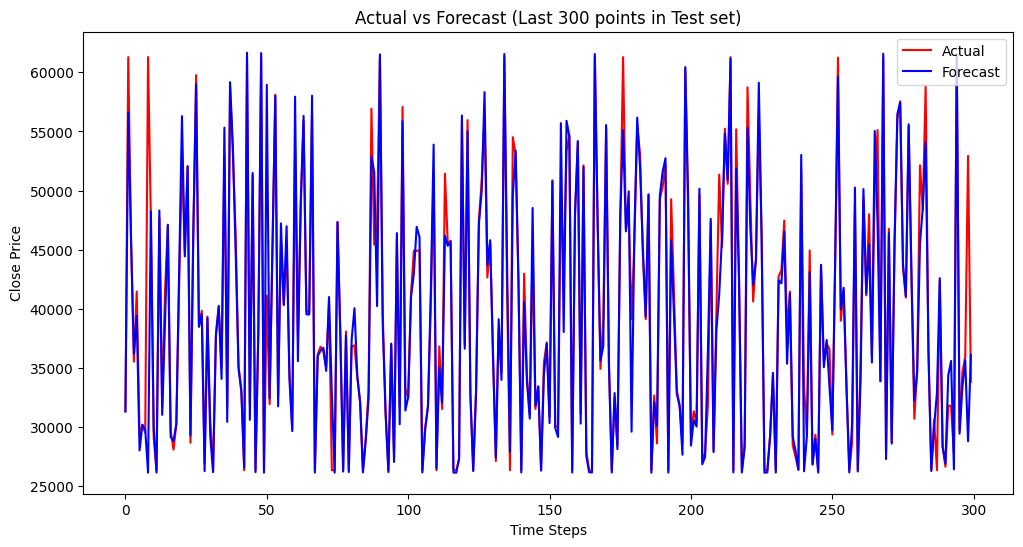

In [45]:
preds_inv, trues_inv = predict_on_test(model, test_loader, scalers, test_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(trues_inv[-300:], color='red', label='Actual')   # 300 điểm cuối
plt.plot(preds_inv[-300:], color='blue', label='Forecast')
plt.legend()
plt.title("Actual vs Forecast (Last 300 points in Test set)")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.show()

